In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Data

data_path = '/Users/helenas/Desktop/Predictive Analytics/Homework/Project2_20231022/BaggageComplaints.csv'

bag_dat = pd.read_csv(data_path)

bag_dat.head
bag_dat.info()
print(bag_dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Airline    252 non-null    object
 1   Date       252 non-null    object
 2   Month      252 non-null    int64 
 3   Year       252 non-null    int64 
 4   Baggage    252 non-null    int64 
 5   Scheduled  252 non-null    int64 
 6   Cancelled  252 non-null    int64 
 7   Enplaned   252 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.9+ KB
            Airline     Date  Month  Year  Baggage  Scheduled  Cancelled  \
0    American Eagle  01/2004      1  2004    12502      38276       2481   
1    American Eagle  02/2004      2  2004     8977      35762        886   
2    American Eagle  03/2004      3  2004    10289      39445       1346   
3    American Eagle  04/2004      4  2004     8095      38982        755   
4    American Eagle  05/2004      5  2004    10618      40422       2206   

In [149]:
bag_dat

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned,Baggage_rate
0,American Eagle,01/2004,1,2004,12502,38276,2481,992360,1.259825
1,American Eagle,02/2004,2,2004,8977,35762,886,1060618,0.846393
2,American Eagle,03/2004,3,2004,10289,39445,1346,1227469,0.838229
3,American Eagle,04/2004,4,2004,8095,38982,755,1234451,0.655757
4,American Eagle,05/2004,5,2004,10618,40422,2206,1267581,0.837659
...,...,...,...,...,...,...,...,...,...
247,United,08/2010,8,2010,14099,30637,344,4263211,0.330713
248,United,09/2010,9,2010,9435,28072,161,3679517,0.256420
249,United,10/2010,10,2010,9565,29144,140,3952549,0.241996
250,United,11/2010,11,2010,8597,27318,104,3573268,0.240592


In [132]:
bag_dat['Baggage_rate'] = bag_dat['Baggage']/bag_dat['Enplaned'] * 100

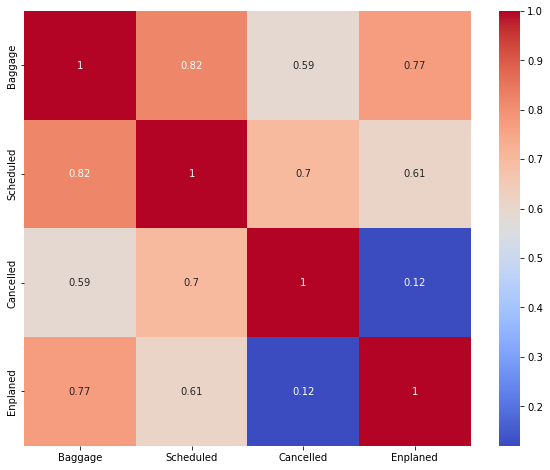

In [4]:
bag_dat_sub = bag_dat.drop(columns=['Airline', 'Date', 'Month', 'Year', 'Baggage_rate'])


# Compute correlations
cormat = bag_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

---
# United, Baggage Claims
1.	Iteratively choose an ARIMA model for the number of canceled flights for United Airlines and produce the forecast for the number of canceled flights for the first 6 months of 2011.
---

In [133]:
united = bag_dat[bag_dat['Airline'] == 'United'].copy()

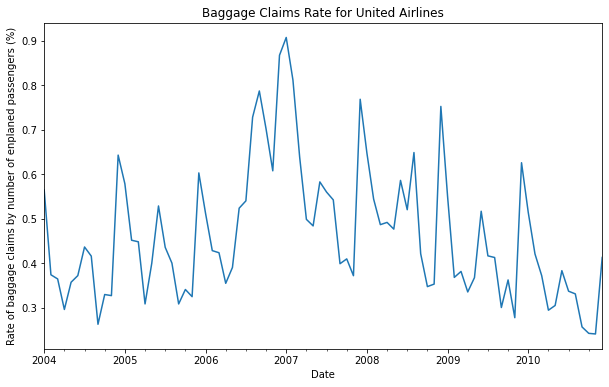

In [145]:
# Convert date column to a date class variable
# Create a monthly index for the series
united['Date'] = pd.to_datetime(united['Date'], format = "%m/%Y")
united_bagrate_ts = pd.Series(united['Baggage_rate'].values, 
                          index = united['Date'])

united_bagrate_ts.index.freq = 'MS'

# Plot the series
plt.figure(figsize = (10, 6))
united_bagrate_ts.plot()
plt.title("Baggage Claims Rate for United Airlines")
plt.xlabel("Date")
plt.ylabel("Rate of baggage claims by number of enplaned passengers (%)")
plt.show()

In [146]:
united[united['Date'] >= '2010-1-1']['Baggage_rate'].mean()

0.34222949958116944

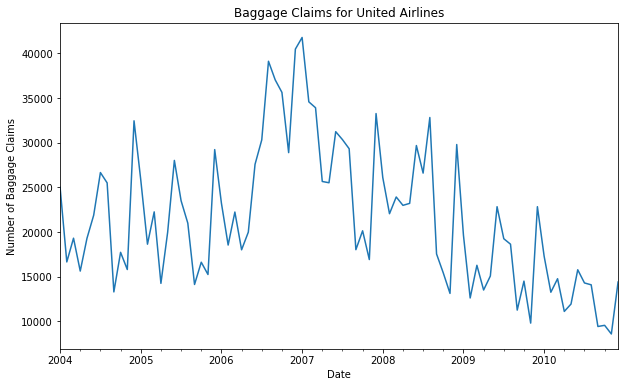

In [144]:
# Convert date column to a date class variable
# Create a monthly index for the series
united['Date'] = pd.to_datetime(united['Date'], format = "%m/%Y")
united_bag_ts = pd.Series(united['Baggage'].values, 
                          index = united['Date'])

united_bag_ts.index.freq = 'MS'

# Plot the series
plt.figure(figsize = (10, 6))
united_bag_ts.plot()
plt.title("Baggage Claims for United Airlines")
plt.xlabel("Date")
plt.ylabel("Number of Baggage Claims")
plt.show()

In [28]:
# Execute the Ljung Box test using 10 lags
bags_united = bag_dat[bag_dat['Airline'] == "United"][['Baggage']]

sm.stats.acorr_ljungbox(bags_united, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,160.317171,2.786746e-29


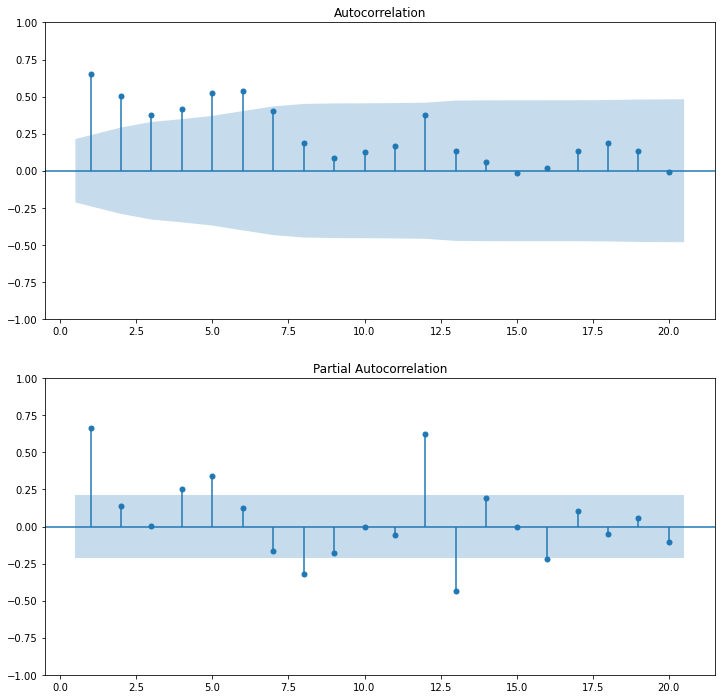

In [10]:
# Plot the ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
plot_acf(united_bag_ts, ax=ax1, zero=False)
plot_pacf(united_bag_ts, ax=ax2, zero=False)
plt.show()

For seasonal time series, the first step in the process is taking a seasonal difference.  To do this, you need to include the seasonal_order(P,D,Q,s) option when you run the ARIMA procedure.  P is the number of seasonal AR terms, Q is the number of seasonal MA terms, s is the length of the seasonal period (for example, s=12 if it takes 12 months to complete the seasonal cycle).  To take a seasonal difference set D=1.

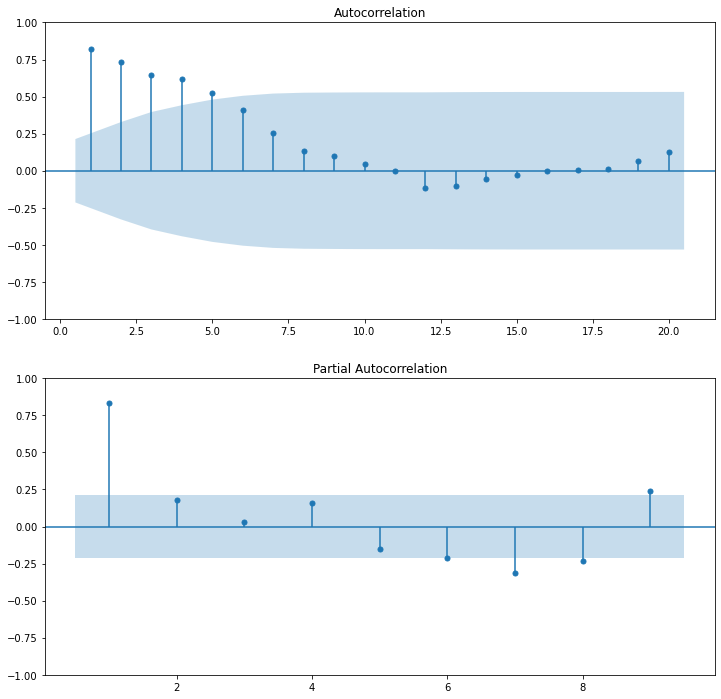

In [11]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12_united_bag = ARIMA(united_bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# Assess the correlation still remaining in the data

residuals12_united_bag = fit_ARD12_united_bag.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12_united_bag, ax=ax1, zero=False)
plot_pacf(residuals12_united_bag, ax=ax2, zero=False, lags=9)
plt.show()

Notice that the ACF and PACF for the residuals look like a typical autoregressive signature, so the next step might be to add p = 1 to include an AR(1) term in the model.  This will not be sufficient to get the residuals to white noise.  Recall that an MA term can help to smooth out a model after differencing.  In this case we took a seasonal difference, so we'll include a seasonal MA term by setting Q=1 in the seasonal order.

Summuary of ARIMA model for United Airlines, Baggage Claims
------------------
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -706.585
Date:                            Sun, 22 Oct 2023   AIC                           1419.170
Time:                                    10:52:27   BIC                           1426.000
Sample:                                01-01-2004   HQIC                          1421.890
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8258      0.035   

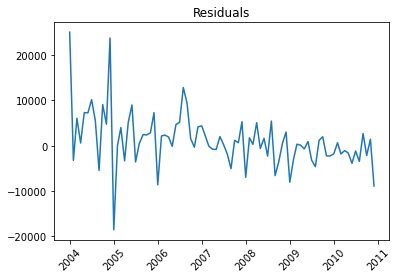

In [117]:
# Fit ARIMA(1,0,0)x(0,1,1)[12] model to the data

# Best model for Baggage Complaints for United is ARIMA(1,0,0)x(0,1,1)[12]
fit_AR1_united_bag = ARIMA(united_bag_ts, order=(1,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print('Summuary of ARIMA model for United Airlines, Baggage Claims')
print('---'*6)
print(fit_AR1_united_bag.summary())

# Examine residuals from the model
residuals_united_bag = fit_AR1_united_bag.resid
plt.plot(residuals_united_bag)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

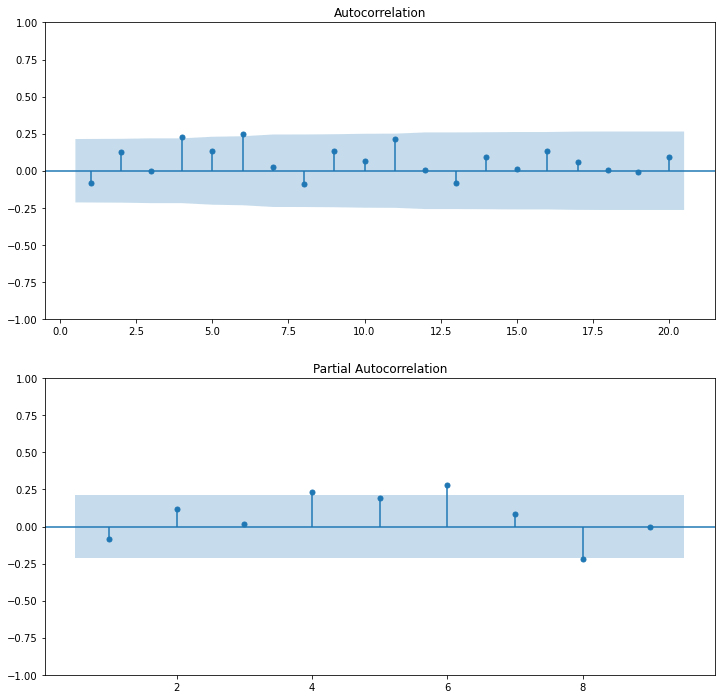

In [13]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals_united_bag, ax=ax1, zero=False)
plot_pacf(residuals_united_bag, ax=ax2, zero=False, lags=9)
plt.show()

After reviewing the ACF and PACF for the resiuals from this model and noticing that the Ljung Box test (below) indicates that the residuals are white noise, this seems to be a reasonable model for the data.

In [14]:
# Execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals_united_bag, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,16.951913,0.075435


Convert predictions into a data frame in order to compute the forecast error

In [19]:
# Generate the predicted values for the series
pred_units_united_bag = fit_AR1_united_bag.get_prediction()
print(pred_units_united_bag)

# Convert to data frame
predicted_mean_united_bag = pred_units_united_bag.predicted_mean
conf_int_united_bag = pred_units_united_bag.conf_int()

prediction_df_united_bag = pd.DataFrame({
    'predicted_mean': predicted_mean_united_bag,
    'lower_bound': conf_int_united_bag.iloc[:, 0],
    'upper_bound': conf_int_united_bag.iloc[:, 1]})

prediction_df_united_bag = prediction_df_united_bag.tail(-1)

prediction_df_united_bag = pd.concat([prediction_df_united_bag,united_bag_ts.to_frame(name='Baggage')],axis=1)
prediction_df_united_bag = prediction_df_united_bag.tail(-1)
prediction_df_united_bag

,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
2004-02-01,19898.744029,9639.203018,30158.285040,16660
2004-03-01,13278.758489,3019.242904,23538.274074,19318
2004-04-01,15061.243598,4805.267090,25317.220106,15638
2004-05-01,12035.958702,1785.483771,22286.433632,19302
2004-06-01,14649.272695,4406.927823,24891.617567,21892
...,...,...,...,...
2010-08-01,17562.923594,9210.297793,25915.549395,14099
2010-09-01,6757.424833,-1595.118905,15109.968571,9435
2010-10-01,11728.158691,3375.735316,20080.582066,9565


Join actual values to predicted values

Calculate the Forecast Error

In [21]:
# Calc error
errors_united_bag = prediction_df_united_bag['Baggage'] - prediction_df_united_bag['predicted_mean']
# Absolue value of error
errors_abs_united_bag = errors_united_bag.abs()
# -- mape --
mape_united_bag = (errors_abs_united_bag/prediction_df_united_bag['Baggage'].abs()).mean()
# -- rmse
rmse_united_bag = (errors_united_bag**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape_united_bag:.3%}')
print(f'RMSE = {rmse_united_bag:,.3f}')

MAPE = 17.942%
RMSE = 5,462.825


Generate the forecast for the next six months

In [22]:
# Generate forecast for the next six months
forecast_united_bag = fit_AR1_united_bag.get_forecast(steps=6)
mean_forecast_united_bag = forecast_united_bag.predicted_mean
confidence_intervals_united_bag = forecast_united_bag.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df_united_bag = pd.DataFrame({
    'Forecasted_CPI': mean_forecast_united_bag,
    'Lower_Bound': confidence_intervals_united_bag.iloc[:, 0],
    'Upper_Bound': confidence_intervals_united_bag.iloc[:, 1]
})

forecast_df_united_bag

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,11517.990008,3166.755594,19869.224422
2011-02-01,8070.936396,-2757.702052,18899.574844
2011-03-01,11672.924019,-560.511300,23906.359338
2011-04-01,9262.037183,-3843.209153,22367.283519
2011-05-01,11463.779640,-2204.058935,25131.618214
2011-06-01,17903.990421,3865.490765,31942.490076


Plot the series and append the six month forecast.  Notice that the forecast follows a pattern similar to the one observed in the actual data

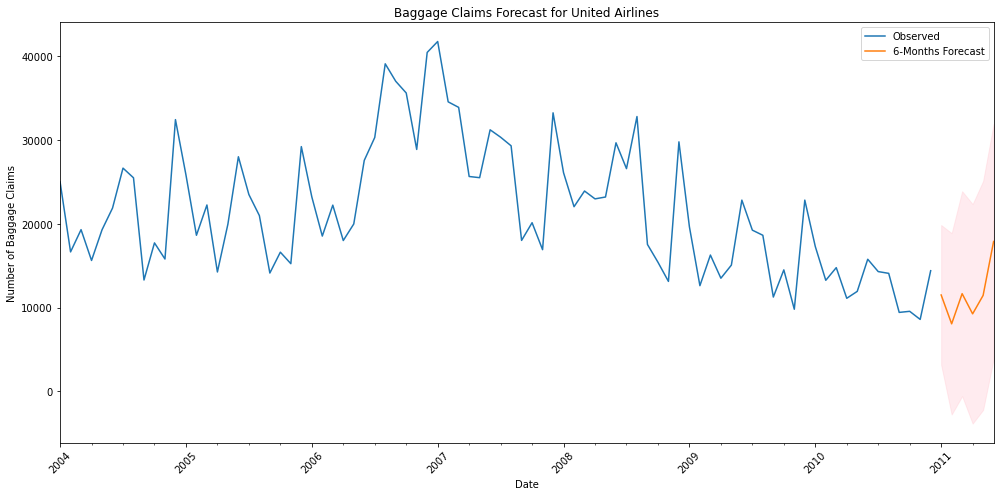

In [107]:
# Plot forecast
plt.figure(figsize=(14, 7))
united_bag_ts.plot(label='Observed', legend=True)
mean_forecast_united_bag.plot(label='6-Months Forecast', legend = True)

plt.fill_between(confidence_intervals_united_bag.index,
                 confidence_intervals_united_bag.iloc[:, 0],
                 confidence_intervals_united_bag.iloc[:, 1],
                 color='pink',
                 alpha=0.3)

plt.title("Baggage Claims Forecast for United Airlines")
plt.xlabel("Date")
plt.ylabel("Number of Baggage Claims")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.legend()
plt.show()

---
# United, Canceled Flight
- Iteratively choose an ARIMA model for the number of canceled flights for United Airlines and produce the forecast for the number of canceled flights for the first 6 months of 2011.
---

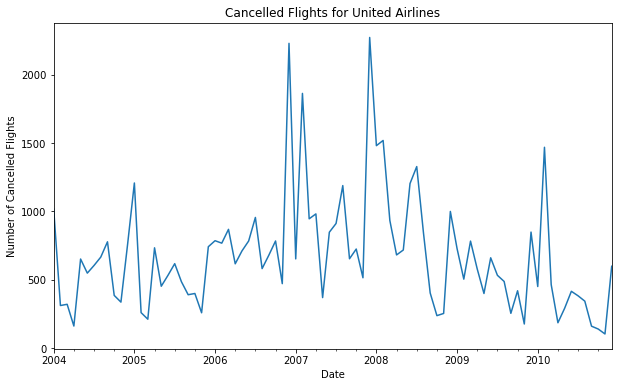

In [111]:
# Convert date column to a date class variable
# Create a monthly index for the series
united_cancelled_ts = pd.Series(united['Cancelled'].values, 
                      index = united['Date'])

united_cancelled_ts.index.freq = 'MS'

# Plot the series
plt.figure(figsize=(10, 6))
united_cancelled_ts.plot()
plt.title("Cancelled Flights for United Airlines")
plt.xlabel("Date")
plt.ylabel("Number of Cancelled Flights")
plt.show()

In [27]:
# Execute the Ljung Box test using 10 lags
cancelled_united = bag_dat[bag_dat['Airline'] == "United"][['Cancelled']]

sm.stats.acorr_ljungbox(cancelled_united, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,37.135304,0.000054


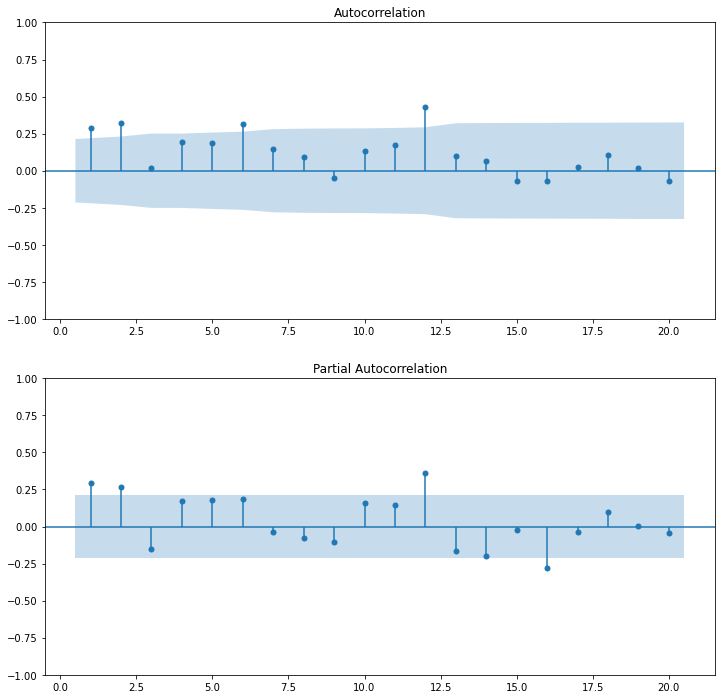

In [29]:
# Plot the ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(united_cancelled_ts, ax=ax1, zero=False)
plot_pacf(united_cancelled_ts, ax=ax2, zero=False)
plt.show()

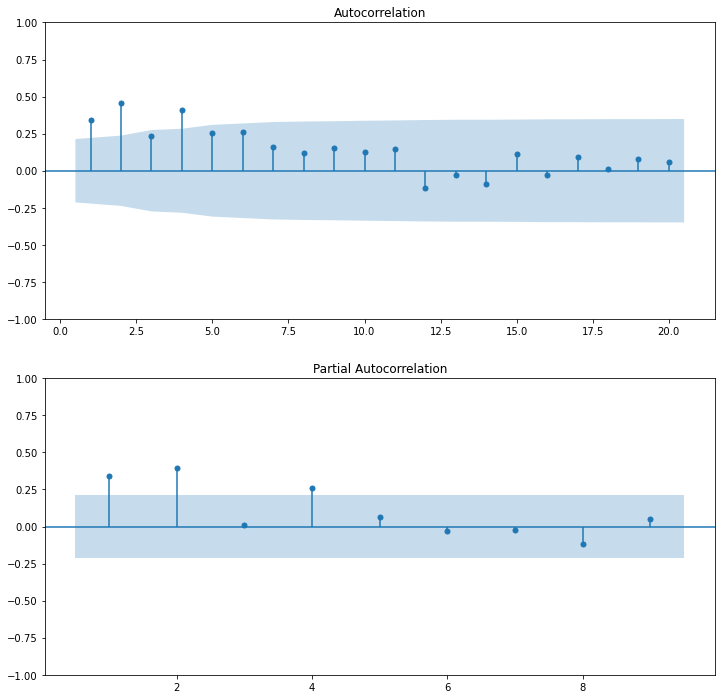

In [30]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12_united_cancelled = ARIMA(united_cancelled_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# Assess the correlation still remaining in the data

residuals12_united_cancelled = fit_ARD12_united_cancelled.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12_united_cancelled, ax=ax1, zero=False)
plot_pacf(residuals12_united_cancelled, ax=ax2, zero=False, lags=9)
plt.show()

Summuary of ARIMA model for United Airlines, Cancelled Flights
------------------
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -528.251
Date:                            Sun, 22 Oct 2023   AIC                           1064.501
Time:                                    10:48:39   BIC                           1073.608
Sample:                                01-01-2004   HQIC                          1068.127
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2038      0.091

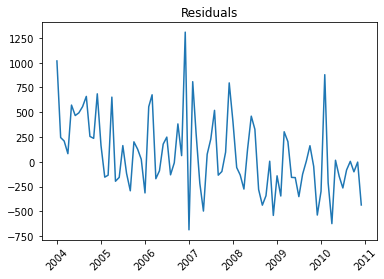

In [116]:
# Fit ARIMA(2,0,0)x(0,1,1)[12] model to the data

# Best model for Cancelled Flights for United is ARIMA(2,0,0)x(0,1,1)[12]
fit_AR2_united_cancelled = ARIMA(united_cancelled_ts, order=(2,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print('Summuary of ARIMA model for United Airlines, Cancelled Flights')
print('---'*6)
print(fit_AR2_united_cancelled.summary())

# Examine residuals from the model
residuals_united_cancelled = fit_AR2_united_cancelled.resid
plt.plot(residuals_united_cancelled)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

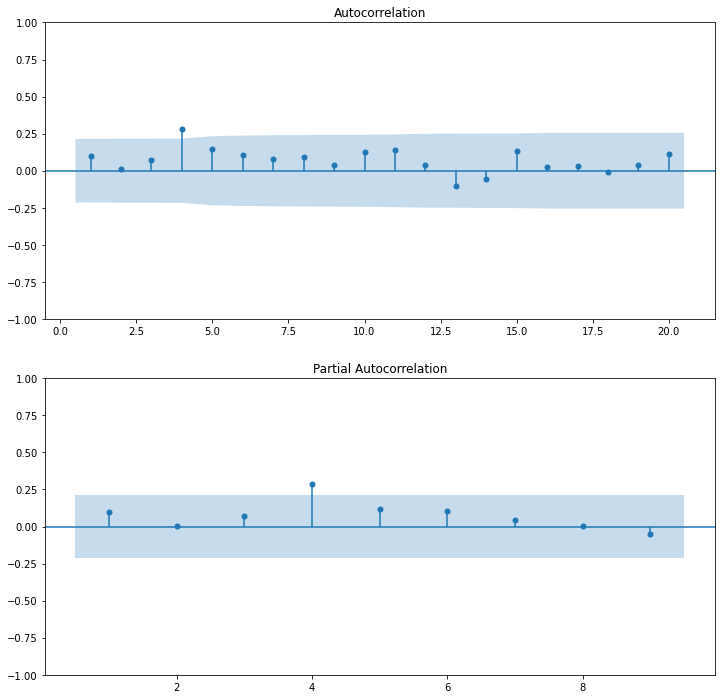

In [33]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals_united_cancelled, ax=ax1, zero=False)
plot_pacf(residuals_united_cancelled, ax=ax2, zero=False, lags=9)
plt.show()

In [34]:
# Execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals_united_cancelled, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,14.645232,0.145541


In [36]:
# Generate the predicted values for the series
pred_units_united_cancelled = fit_AR2_united_cancelled.get_prediction()
print(pred_units_united_cancelled)

# Convert to data frame
predicted_mean_united_cancelled = pred_units_united_cancelled.predicted_mean
conf_int_united_cancelled = pred_units_united_cancelled.conf_int()

prediction_df_united_cancelled = pd.DataFrame({
    'predicted_mean': predicted_mean_united_cancelled,
    'lower_bound': conf_int_united_cancelled.iloc[:, 0],
    'upper_bound': conf_int_united_cancelled.iloc[:, 1]})

prediction_df_united_cancelled = prediction_df_united_cancelled.tail(-1)

prediction_df_united_cancelled = pd.concat([prediction_df_united_cancelled, united_cancelled_ts.to_frame(name='Cancelled')],axis=1)
prediction_df_united_cancelled = prediction_df_united_cancelled.tail(-1)
prediction_df_united_cancelled

,predicted_mean,lower_bound,upper_bound,Cancelled
Date,,,,
2004-02-01,67.689416,-2111.295554,2246.674386,312
2004-03-01,111.617094,-2058.288271,2281.522459,321
2004-04-01,80.478288,-2088.197689,2249.154264,162
2004-05-01,80.234822,-2087.262467,2247.732111,652
2004-06-01,82.668753,-2084.667908,2250.005415,549
...,...,...,...,...
2010-08-01,426.723747,-276.791604,1130.239098,344
2010-09-01,156.688858,-546.821864,860.199580,161
2010-10-01,241.330366,-462.179152,944.839884,140


In [37]:
# Calc error
errors_united_cancelled = prediction_df_united_cancelled['Cancelled'] - prediction_df_united_cancelled['predicted_mean']
# Absolue value of error
errors_abs_united_cancelled = errors_united_cancelled.abs()
# -- mape --
mape_united_cancelled = (errors_abs_united_cancelled/prediction_df_united_cancelled['Cancelled'].abs()).mean()
# -- rmse
rmse_united_cancelled = (errors_united_cancelled**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape_united_cancelled:.3%}')
print(f'RMSE = {rmse_united_cancelled:,.3f}')

MAPE = 48.698%
RMSE = 380.126


In [38]:
# Generate forecast for the next six months
forecast_united_cancelled = fit_AR2_united_cancelled.get_forecast(steps=6)
mean_forecast_united_cancelled = forecast_united_cancelled.predicted_mean
confidence_intervals_united_cancelled = forecast_united_cancelled.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df_united_cancelled = pd.DataFrame({
    'Forecasted_CPI': mean_forecast_united_cancelled,
    'Lower_Bound': confidence_intervals_united_cancelled.iloc[:, 0],
    'Upper_Bound': confidence_intervals_united_cancelled.iloc[:, 1]
})

forecast_df_united_cancelled

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,547.621832,-155.670041,1250.913705
2011-02-01,852.413748,134.680391,1570.147104
2011-03-01,509.236256,-282.371499,1300.844010
2011-04-01,303.110520,-499.121728,1105.342768
2011-05-01,325.908943,-494.398470,1146.216356
2011-06-01,562.942854,-262.429258,1388.314966


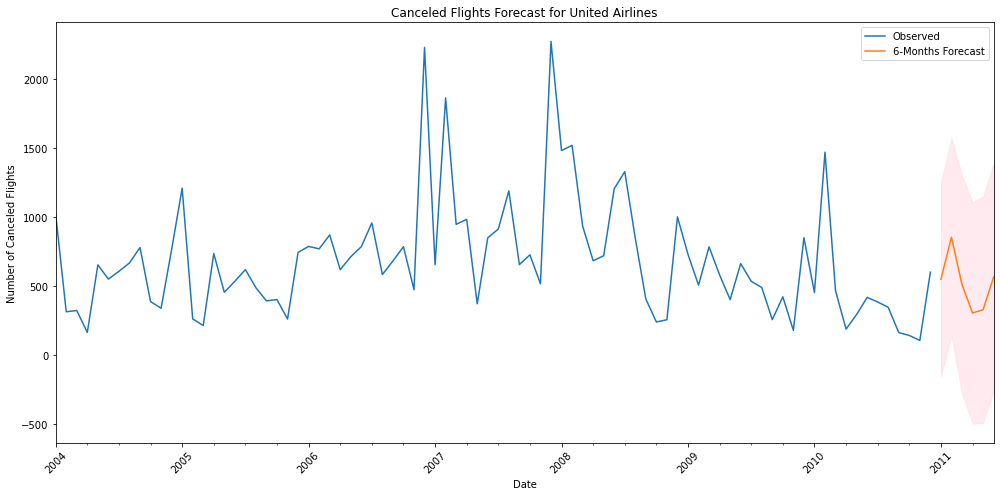

In [108]:
# Plot forecast
plt.figure(figsize=(14, 7))
united_cancelled_ts.plot(label='Observed', legend=True)
mean_forecast_united_cancelled.plot(label='6-Months Forecast', legend = True)

plt.fill_between(confidence_intervals_united_cancelled.index,
                 confidence_intervals_united_cancelled.iloc[:, 0],
                 confidence_intervals_united_cancelled.iloc[:, 1],
                 color='pink',
                 alpha=0.3)

plt.title("Canceled Flights Forecast for United Airlines")
plt.xlabel("Date")
plt.ylabel("Number of Canceled Flights")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.legend()
plt.show()

---
# United, Correlation Heatmap
- Examine the correlation between the number of baggage claims and the number of canceled flights, passengers enplaned, and flights scheduled.
---

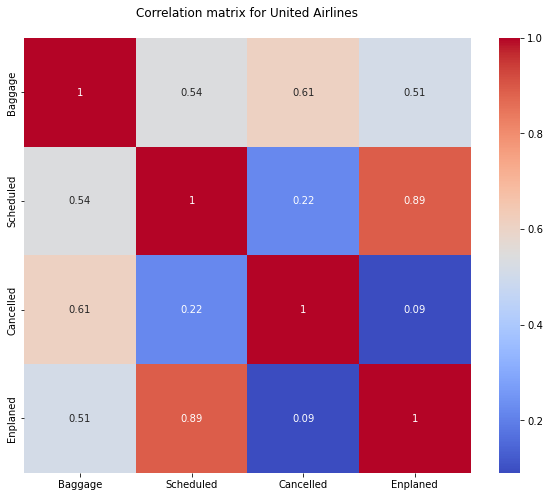

In [128]:
united_sub = united.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat_united = united_sub.corr()

# Round correlation matrix to 2 decimal places
cormat_united = cormat_united.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat_united,annot=True, cmap = 'coolwarm',)
plt.title('Correlation matrix for United Airlines'+'\n')
plt.show()

---
# American Eagle, Baggage Claims
- Iteratively choose an ARIMA model for the number of baggage claims for American Eagle and produce the forecast for the number of baggage claims expected for the first 6 months of 2011. 
---

In [136]:
eagle = bag_dat[bag_dat['Airline'] == 'American Eagle'].copy()

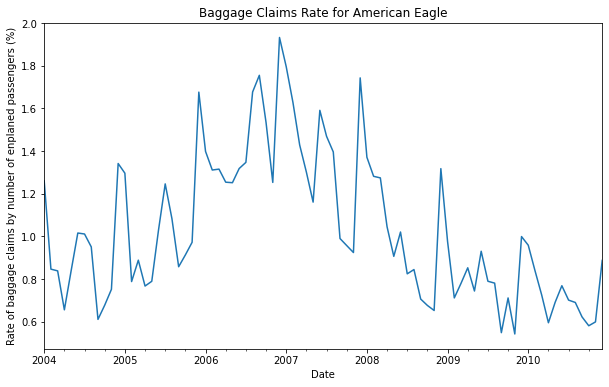

In [138]:
# Convert date column to a date class variable
# Create a monthly index for the series
eagle['Date'] = pd.to_datetime(eagle['Date'], format = "%m/%Y")
eagle_bagrate_ts = pd.Series(eagle['Baggage_rate'].values, 
                             index = eagle['Date'])

eagle_bagrate_ts.index.freq = 'MS'

# Plot the series
plt.figure(figsize = (10, 6))
eagle_bagrate_ts.plot()
plt.title("Baggage Claims Rate for American Eagle")
plt.xlabel("Date")
plt.ylabel("Rate of baggage claims by number of enplaned passengers (%)")
plt.show()

In [142]:
eagle[eagle['Date'] >= '2010-1-1']['Baggage_rate'].mean()

0.7216518305391788

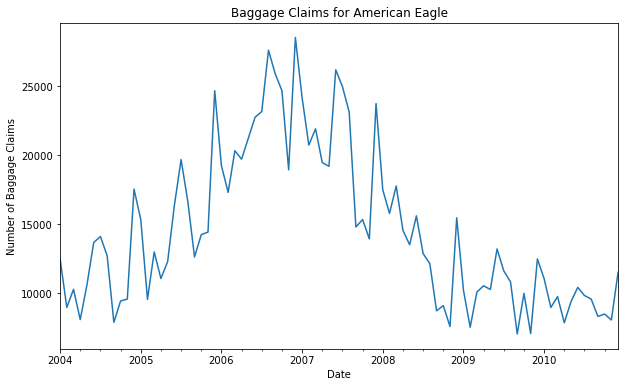

In [137]:
# Convert date column to a date class variable
# Create a monthly index for the series
eagle['Date'] = pd.to_datetime(eagle['Date'], format = "%m/%Y")
eagle_bag_ts = pd.Series(eagle['Baggage'].values, 
                         index = eagle['Date'])

eagle_bag_ts.index.freq = 'MS'

# Plot the series
plt.figure(figsize = (10, 6))
eagle_bag_ts.plot()
plt.title("Baggage Claims for American Eagle")
plt.xlabel("Date")
plt.ylabel("Number of Baggage Claims")
plt.show()

In [45]:
# Execute the Ljung Box test using 10 lags
bags_eagle = bag_dat[bag_dat['Airline'] == "American Eagle"][['Baggage']]

sm.stats.acorr_ljungbox(bags_eagle, lags = [10], return_df = True)

,lb_stat,lb_pvalue
10,363.970723,4.308185e-72


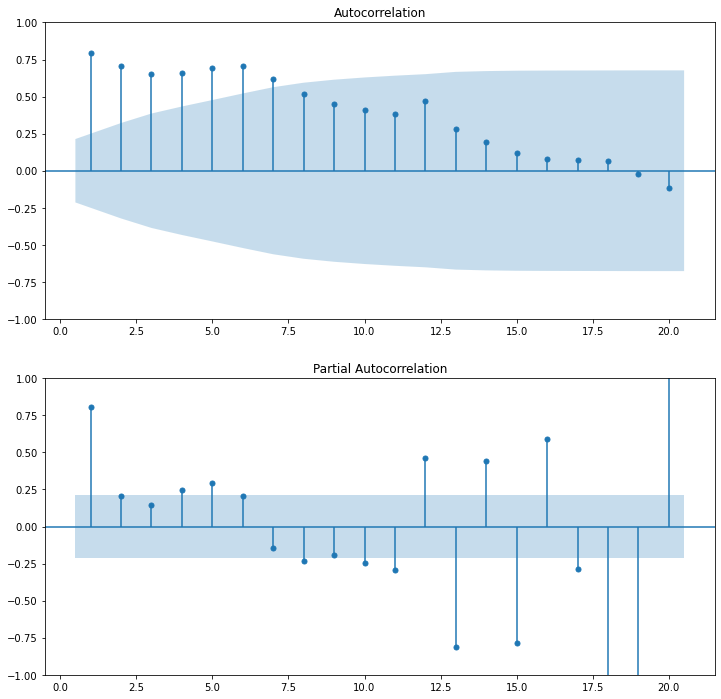

In [50]:
# Plot the ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
plot_acf(eagle_bag_ts, ax=ax1, zero=False)
plot_pacf(eagle_bag_ts, ax=ax2, zero=False)
plt.show()

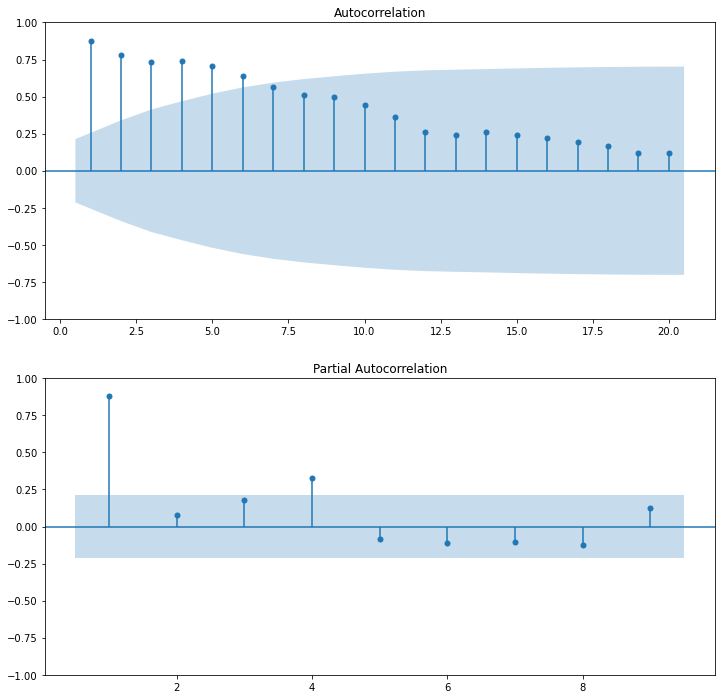

In [49]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12_eagle_bag = ARIMA(eagle_bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# Assess the correlation still remaining in the data

residuals12_eagle_bag = fit_ARD12_eagle_bag.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12_eagle_bag, ax=ax1, zero=False)
plot_pacf(residuals12_eagle_bag, ax=ax2, zero=False, lags=9)
plt.show()

Summuary of ARIMA model for American Eagle, Baggage Claims
------------------
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -669.273
Date:                            Sun, 22 Oct 2023   AIC                           1344.546
Time:                                    11:09:38   BIC                           1351.376
Sample:                                01-01-2004   HQIC                          1347.265
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9322      0.025    

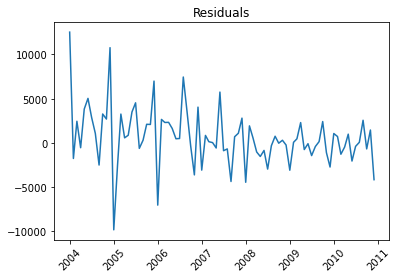

In [125]:
# Fit ARIMA(1,0,0)x(0,1,1)[12] model to the data

# Best model for Baggage Complaints for United is ARIMA(1,0,0)x(0,1,1)[12]
fit_AR1_eagle_bag = ARIMA(eagle_bag_ts, order=(1,0,0), seasonal_order=(0, 1, 1, 12)).fit()

# Summary of the ARIMA model
print('Summuary of ARIMA model for American Eagle, Baggage Claims')
print('---'*6)
print(fit_AR1_eagle_bag.summary())

# Examine residuals from the model
residuals_eagle_bag = fit_AR1_eagle_bag.resid
plt.plot(residuals_eagle_bag)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

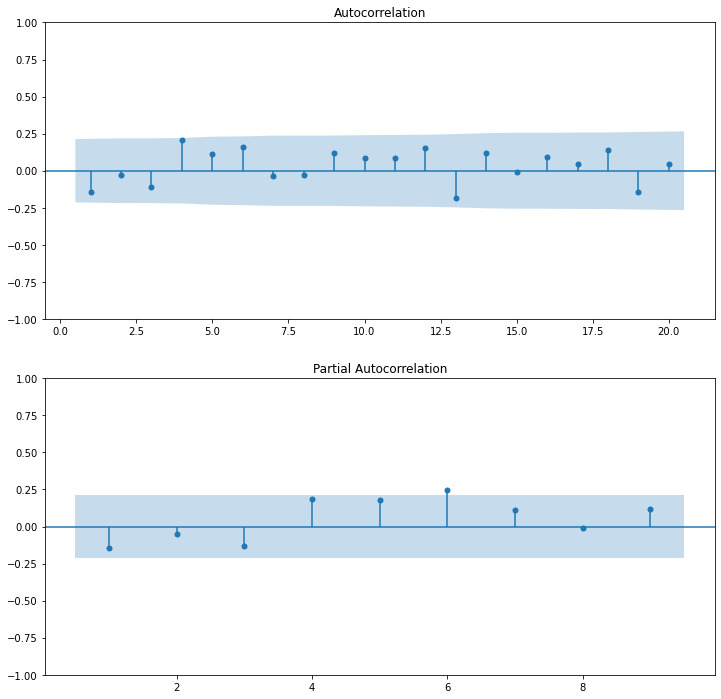

In [52]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals_eagle_bag, ax=ax1, zero=False)
plot_pacf(residuals_eagle_bag, ax=ax2, zero=False, lags=9)
plt.show()

In [53]:
# Execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals_eagle_bag, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.581161,0.248041


In [54]:
# Generate the predicted values for the series
pred_units_eagle_bag = fit_AR1_eagle_bag.get_prediction()
print(pred_units_eagle_bag)

# Convert to data frame
predicted_mean_eagle_bag = pred_units_eagle_bag.predicted_mean
conf_int_eagle_bag = pred_units_eagle_bag.conf_int()

prediction_df_eagle_bag = pd.DataFrame({
    'predicted_mean': predicted_mean_eagle_bag,
    'lower_bound': conf_int_eagle_bag.iloc[:, 0],
    'upper_bound': conf_int_eagle_bag.iloc[:, 1]})

prediction_df_eagle_bag = prediction_df_eagle_bag.tail(-1)

prediction_df_eagle_bag = pd.concat([prediction_df_eagle_bag,eagle_bag_ts.to_frame(name='Baggage')],axis=1)
prediction_df_eagle_bag = prediction_df_eagle_bag.tail(-1)
prediction_df_eagle_bag

,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
2004-02-01,10741.483865,4154.034411,17328.933319,8977
2004-03-01,7851.631770,1266.948016,14436.315525,10289
2004-04-01,8645.248534,2066.423565,15224.073503,8095
2004-05-01,6801.569886,231.638659,13371.501112,10618
2004-06-01,8661.787505,2102.655252,15220.919758,13684
...,...,...,...,...
2010-08-01,9522.188631,4863.853817,14180.523444,9583
2010-09-01,5773.862064,1116.238313,10431.485814,8324
2010-10-01,9182.599039,4525.797252,13839.400825,8498


In [55]:
# Calc error
errors_eagle_bag = prediction_df_eagle_bag['Baggage'] - prediction_df_eagle_bag['predicted_mean']
# Absolue value of error
errors_abs_eagle_bag = errors_eagle_bag.abs()
# -- mape --
mape_eagle_bag = (errors_abs_eagle_bag/prediction_df_eagle_bag['Baggage'].abs()).mean()
# -- rmse
rmse_eagle_bag = (errors_eagle_bag**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape_eagle_bag:.3%}')
print(f'RMSE = {rmse_eagle_bag:,.3f}')

MAPE = 14.710%
RMSE = 3,004.210


In [56]:
# Generate forecast for the next six months
forecast_eagle_bag = fit_AR1_eagle_bag.get_forecast(steps=6)
mean_forecast_eagle_bag = forecast_eagle_bag.predicted_mean
confidence_intervals_eagle_bag = forecast_eagle_bag.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df_eagle_bag = pd.DataFrame({
    'Forecasted_CPI': mean_forecast_eagle_bag,
    'Lower_Bound': confidence_intervals_eagle_bag.iloc[:, 0],
    'Upper_Bound': confidence_intervals_eagle_bag.iloc[:, 1]
})

forecast_df_eagle_bag

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,9288.020443,4638.840878,13937.200008
2011-02-01,6723.942849,388.343373,13059.542324
2011-03-01,8761.914097,1267.439943,16256.388252
2011-04-01,7338.663764,-1031.274599,15708.602127
2011-05-01,8084.123928,-975.968680,17144.216535
2011-06-01,10955.028183,1337.669734,20572.386632


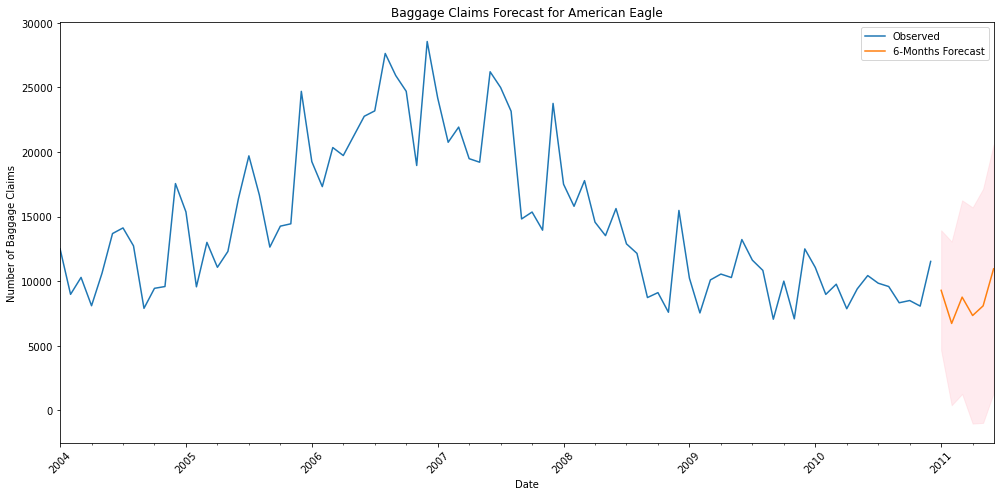

In [124]:
# Plot forecast
plt.figure(figsize=(14, 7))
eagle_bag_ts.plot(label='Observed', legend=True)
mean_forecast_eagle_bag.plot(label='6-Months Forecast', legend = True)

plt.fill_between(confidence_intervals_eagle_bag.index,
                 confidence_intervals_eagle_bag.iloc[:, 0],
                 confidence_intervals_eagle_bag.iloc[:, 1],
                 color='pink',
                 alpha=0.3)

plt.title("Baggage Claims Forecast for American Eagle")
plt.xlabel("Date")
plt.ylabel("Number of Baggage Claims")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.legend()
plt.show()

---
# American Eagle, Canceled Flights
- Iteratively choose an ARIMA model for the number of canceled flights for American Eagle and produce the forecast for the number of canceled flights for the first 6 months of 2011.
---

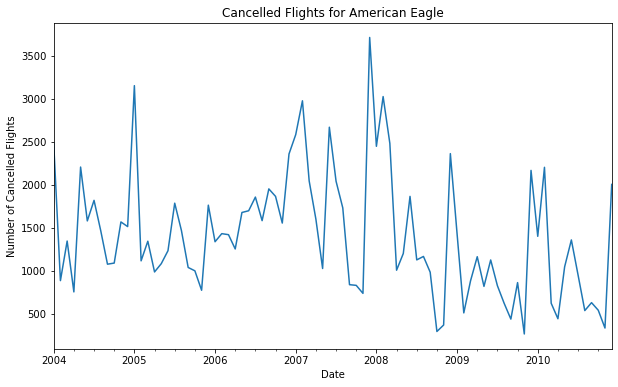

In [82]:
# Convert date column to a date class variable
# Create a monthly index for the series
eagle_cancelled_ts = pd.Series(eagle['Cancelled'].values, 
                      index = eagle['Date'])

eagle_cancelled_ts.index.freq = 'MS'

# Plot the series
plt.figure(figsize=(10, 6))
eagle_cancelled_ts.plot()
plt.title("Cancelled Flights for American Eagle")
plt.xlabel("Date")
plt.ylabel("Number of Cancelled Flights")
plt.show()

In [60]:
# Execute the Ljung Box test using 10 lags
cancelled_eagle = bag_dat[bag_dat['Airline'] == "American Eagle"][['Cancelled']]

sm.stats.acorr_ljungbox(cancelled_eagle, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,33.222572,0.00025


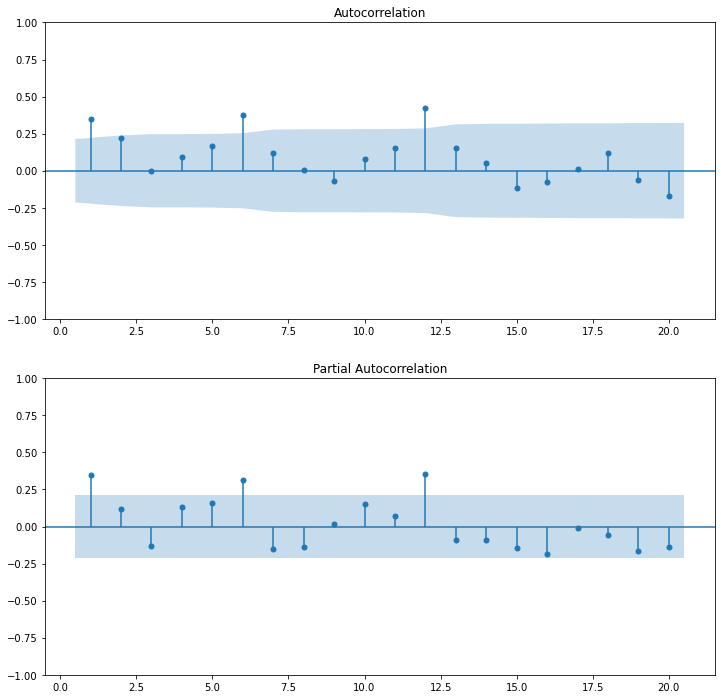

In [61]:
# Plot the ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(eagle_cancelled_ts, ax=ax1, zero=False)
plot_pacf(eagle_cancelled_ts, ax=ax2, zero=False)
plt.show()

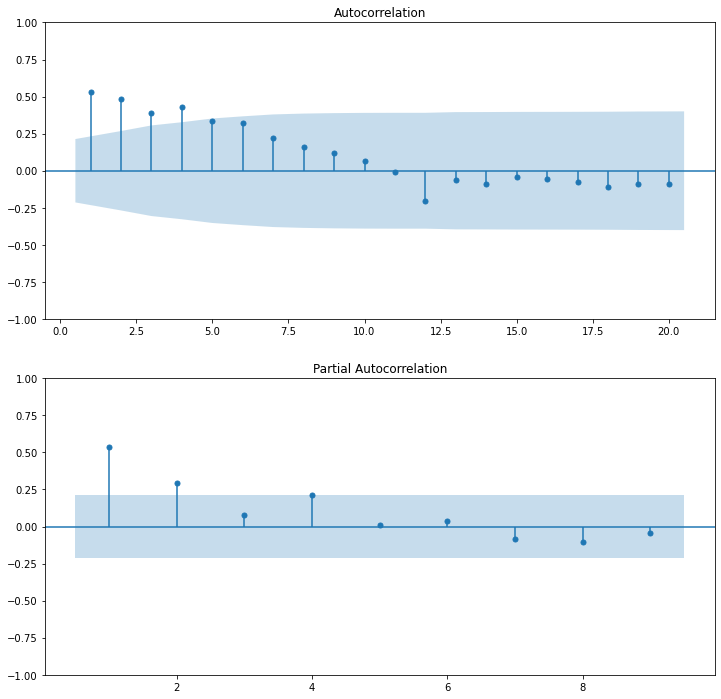

In [62]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12_eagle_cancelled = ARIMA(eagle_cancelled_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# Assess the correlation still remaining in the data

residuals12_eagle_cancelled = fit_ARD12_eagle_cancelled.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12_eagle_cancelled, ax=ax1, zero=False)
plot_pacf(residuals12_eagle_cancelled, ax=ax2, zero=False, lags=9)
plt.show()

Summuary of ARIMA model for American Eagle, Cancelled Flighs
------------------
                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   84
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -561.808
Date:                          Sun, 22 Oct 2023   AIC                           1131.615
Time:                                  11:11:02   BIC                           1140.722
Sample:                              01-01-2004   HQIC                          1135.241
                                   - 12-01-2010                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9370      0.061     15.312      0

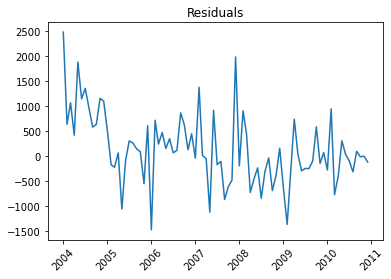

In [126]:
# Fit ARIMA(1,0,1)x(0,1,1)[12] model to the data

# Best model for Cancelled Flights for United is ARIMA(1,0,0)x(0,1,1)[12]
fit_ARMA1_eagle_cancelled = ARIMA(eagle_cancelled_ts, order=(1,0,1), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print('Summuary of ARIMA model for American Eagle, Cancelled Flighs')
print('---'*6)
print(fit_ARMA1_eagle_cancelled.summary())

# Examine residuals from the model
residuals_eagle_cancelled = fit_ARMA1_eagle_cancelled.resid
plt.plot(residuals_eagle_cancelled)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

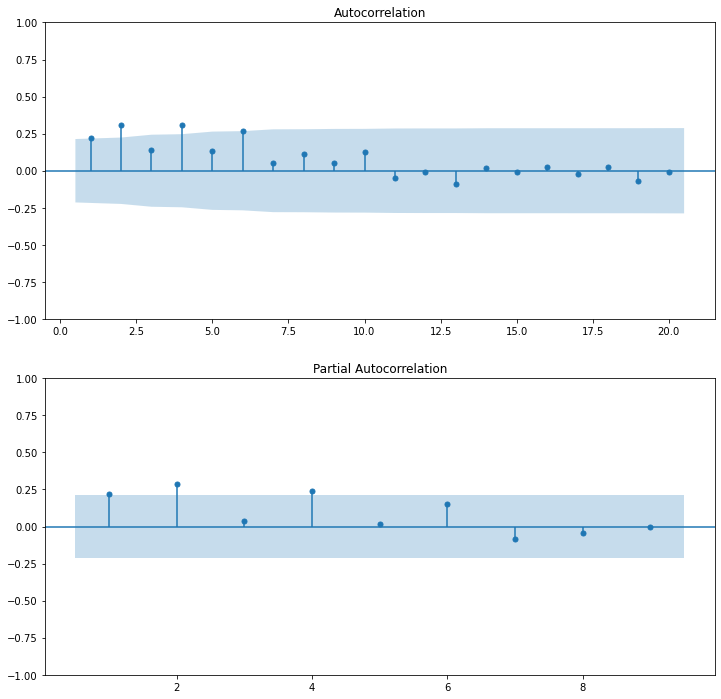

In [76]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals_eagle_cancelled, ax=ax1, zero=False)
plot_pacf(residuals_eagle_cancelled, ax=ax2, zero=False, lags=9)
plt.show()

In [77]:
# Execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals_eagle_cancelled, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,35.045433,0.000123


In [81]:
#Take the first difference of the series
eagle2 = eagle.drop(index=0)
eagle2['Cancelled_diff'] = np.diff(eagle['Cancelled'], n=1)
eagle2 =eagle2[['Date','Cancelled_diff']]
eagle2

,Date,Cancelled_diff
1,2004-02-01,-1595
2,2004-03-01,460
3,2004-04-01,-591
4,2004-05-01,1451
5,2004-06-01,-626
...,...,...
79,2010-08-01,-412
80,2010-09-01,92
81,2010-10-01,-88
82,2010-11-01,-207


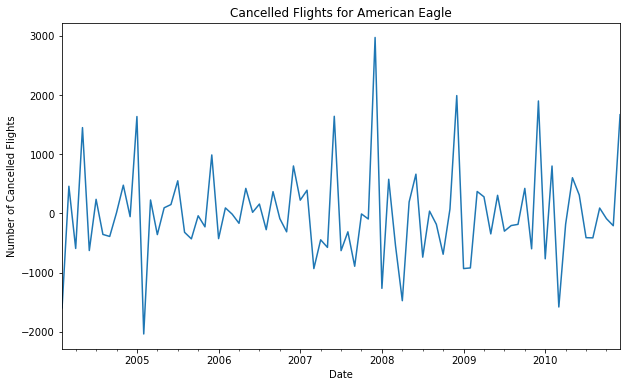

In [85]:
# Convert date column to a date class variable
# Create a monthly index for the series
eagle_cancelled_ts2 = pd.Series(eagle2['Cancelled_diff'].values, 
                      index = eagle2['Date'])

eagle_cancelled_ts2.index.freq = 'MS'

# Plot the series
plt.figure(figsize=(10, 6))
eagle_cancelled_ts2.plot()
plt.title("Cancelled Flights for American Eagle")
plt.xlabel("Date")
plt.ylabel("Number of Cancelled Flights")
plt.show()

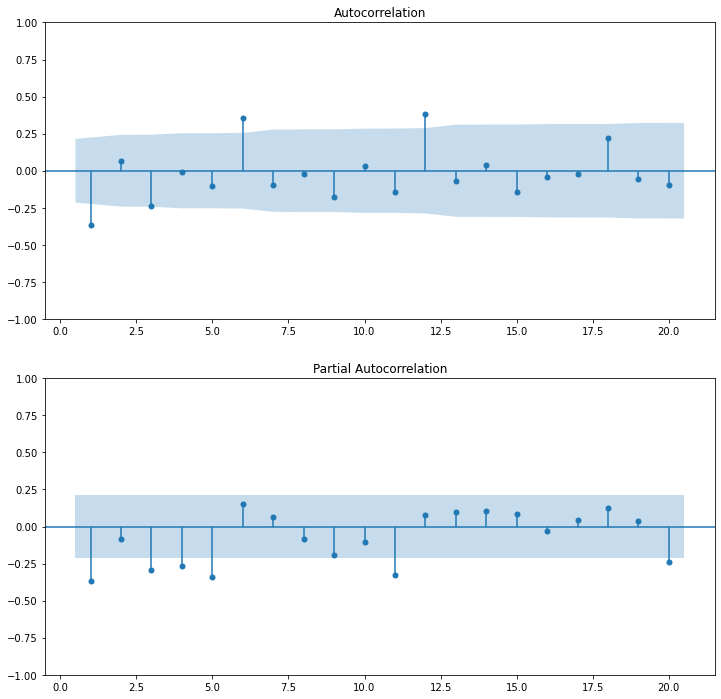

In [86]:
# Plot the ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(eagle_cancelled_ts2, ax=ax1, zero=False)
plot_pacf(eagle_cancelled_ts2, ax=ax2, zero=False)
plt.show()

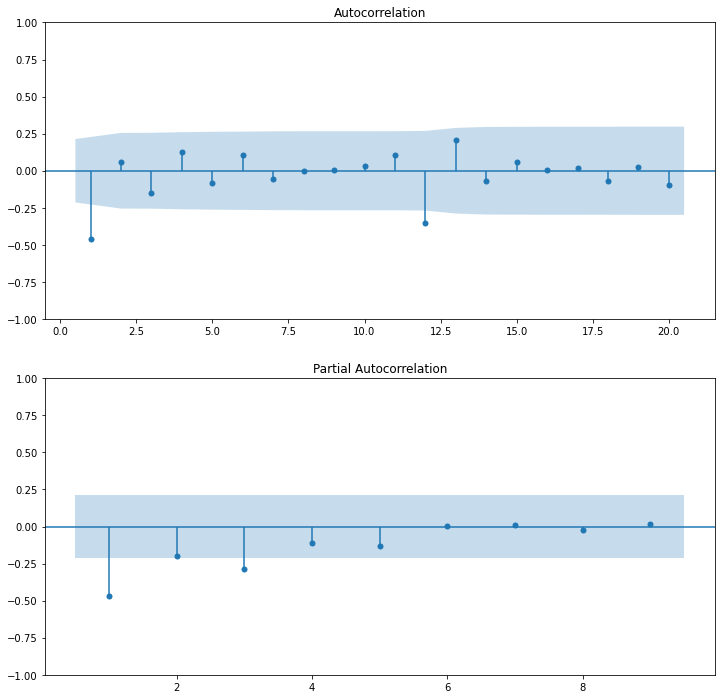

In [93]:
# Fit ARIMA(0,1,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12_eagle_cancelled2 = ARIMA(eagle_cancelled_ts, order=(0,1,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# Assess the correlation still remaining in the data

residuals12_eagle_cancelled2 = fit_ARD12_eagle_cancelled2.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12_eagle_cancelled2, ax=ax1, zero=False)
plot_pacf(residuals12_eagle_cancelled2, ax=ax2, zero=False, lags=9)
plt.show()

Summuary of ARIMA model for American Eagle, Cancelled Flighs
------------------
                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   84
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -555.732
Date:                          Sun, 22 Oct 2023   AIC                           1117.464
Time:                                  11:11:26   BIC                           1124.252
Sample:                              01-01-2004   HQIC                          1120.163
                                   - 12-01-2010                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7398      0.080     -9.236      0

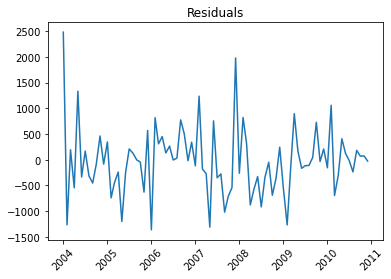

In [127]:
# Fit ARIMA(0,1,1)x(0,1,1)[12] model to the data

# Best model for Cancelled Flights for United is ARIMA(0,1,1)x(0,1,1)[12]
fit_MA1_eagle_cancelled2 = ARIMA(eagle_cancelled_ts, order=(0,1,1), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print('Summuary of ARIMA model for American Eagle, Cancelled Flighs')
print('---'*6)
print(fit_MA1_eagle_cancelled2.summary())

# Examine residuals from the model
residuals_eagle_cancelled2 = fit_MA1_eagle_cancelled2.resid
plt.plot(residuals_eagle_cancelled2)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

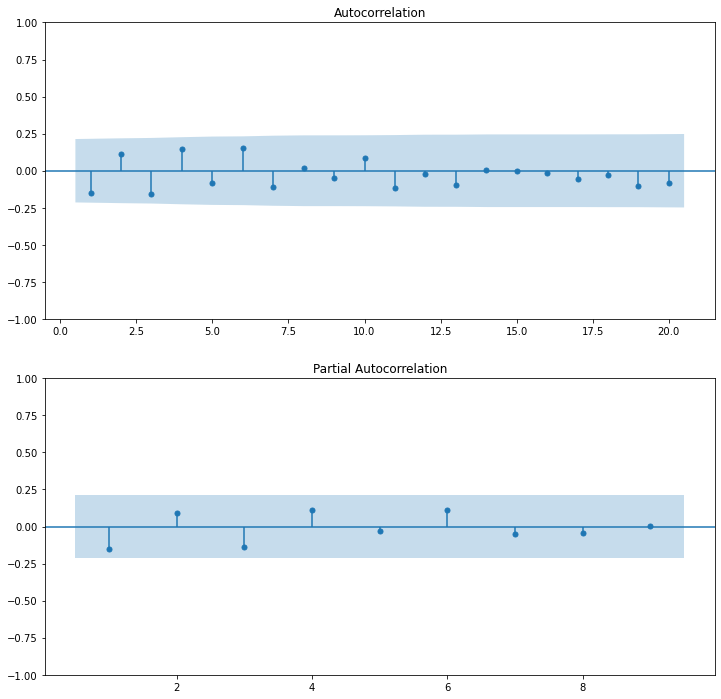

In [95]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals_eagle_cancelled2, ax=ax1, zero=False)
plot_pacf(residuals_eagle_cancelled2, ax=ax2, zero=False, lags=9)
plt.show()

In [96]:
# Execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals_eagle_cancelled2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.054302,0.281439


In [98]:
# Generate the predicted values for the series
pred_units_eagle_cancelled = fit_MA1_eagle_cancelled2.get_prediction()
print(pred_units_eagle_cancelled)

# Convert to data frame
predicted_mean_eagle_cancelled = pred_units_eagle_cancelled.predicted_mean
conf_int_eagle_cancelled = pred_units_eagle_cancelled.conf_int()

prediction_df_eagle_cancelled = pd.DataFrame({
    'predicted_mean': predicted_mean_eagle_cancelled,
    'lower_bound': conf_int_eagle_cancelled.iloc[:, 0],
    'upper_bound': conf_int_eagle_cancelled.iloc[:, 1]})

prediction_df_eagle_cancelled = prediction_df_eagle_cancelled.tail(-1)

prediction_df_eagle_cancelled = pd.concat([prediction_df_eagle_cancelled, eagle_cancelled_ts.to_frame(name='Cancelled')],axis=1)
prediction_df_eagle_cancelled = prediction_df_eagle_cancelled.tail(-1)
prediction_df_eagle_cancelled

,predicted_mean,lower_bound,upper_bound,Cancelled
Date,,,,
2004-02-01,2156.130768,-404.690259,4716.951794,886
2004-03-01,1154.339974,-1384.658753,3693.338700,1346
2004-04-01,1304.809035,-1233.194388,3842.812458,755
2004-05-01,873.255910,-1664.701495,3411.213316,2206
2004-06-01,1919.335775,-618.619502,4457.291051,1580
...,...,...,...,...
2010-08-01,777.276555,-373.771218,1928.324327,538
2010-09-01,449.935070,-701.105642,1600.975783,630
2010-10-01,474.246259,-676.790896,1625.283415,542


In [100]:
# Calc error
errors_eagle_cancelled = prediction_df_eagle_cancelled['Cancelled'] - prediction_df_eagle_cancelled['predicted_mean']
# Absolue value of error
errors_abs_eagle_cancelled = errors_eagle_cancelled.abs()
# -- mape --
mape_eagle_cancelled = (errors_abs_eagle_cancelled/prediction_df_eagle_cancelled['Cancelled'].abs()).mean()
# -- rmse
rmse_eagle_cancelled = (errors_eagle_cancelled**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape_eagle_cancelled:.3%}')
print(f'RMSE = {rmse_eagle_cancelled:,.3f}')

MAPE = 40.851%
RMSE = 606.978


In [147]:
# Generate forecast for the next six months
forecast_eagle_cancelled = fit_MA1_eagle_cancelled2.get_forecast(steps=6)
mean_forecast_eagle_cancelled = forecast_eagle_cancelled.predicted_mean
confidence_intervals_eagle_cancelled = forecast_eagle_cancelled.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df_eagle_cancelled = pd.DataFrame({
    'Forecasted_CPI': mean_forecast_eagle_cancelled,
    'Lower_Bound': confidence_intervals_eagle_cancelled.iloc[:, 0],
    'Upper_Bound': confidence_intervals_eagle_cancelled.iloc[:, 1]
})

forecast_df_eagle_cancelled

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,1460.406849,309.808730,2611.004968
2011-02-01,1505.445611,316.510764,2694.380459
2011-03-01,879.431004,-346.615745,2105.477752
2011-04-01,564.038164,-698.025005,1826.101333
2011-05-01,760.709863,-536.369252,2057.788978
2011-06-01,1191.057523,-140.116648,2522.231695


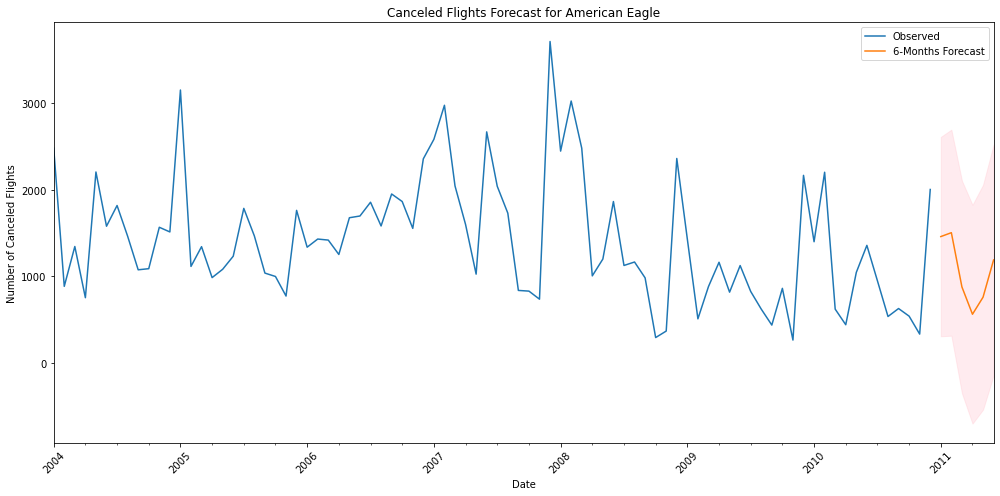

In [148]:
# Plot forecast
plt.figure(figsize=(14, 7))
eagle_cancelled_ts.plot(label='Observed', legend=True)
mean_forecast_eagle_cancelled.plot(label='6-Months Forecast', legend = True)

plt.fill_between(confidence_intervals_eagle_cancelled.index,
                 confidence_intervals_eagle_cancelled.iloc[:, 0],
                 confidence_intervals_eagle_cancelled.iloc[:, 1],
                 color='pink',
                 alpha=0.3)

plt.title("Canceled Flights Forecast for American Eagle")
plt.xlabel("Date")
plt.ylabel("Number of Canceled Flights")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.legend()
plt.show()

---
# American Eagle, Correlation Heatmap
- Examine the correlation between the number of baggage claims and the number of canceled flights, passengers enplaned, and flights scheduled.
---

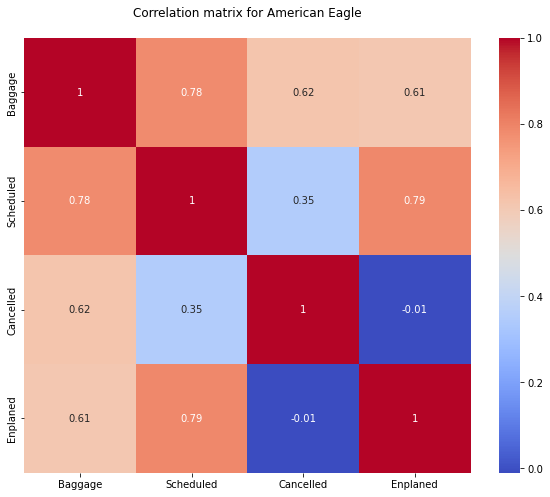

In [122]:
eagle_sub = eagle.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat_eagle = eagle_sub.corr()

# Round correlation matrix to 2 decimal places
cormat_eagle = cormat_eagle.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat_eagle, annot=True, cmap = 'coolwarm')
plt.title('Correlation matrix for American Eagle'+'\n')
plt.show()